<a href="https://colab.research.google.com/github/KESHAVNATH8/Machine-Learning-Project/blob/main/TiltedInvoice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from scipy.spatial import distance as dist
from imutils import perspective

In [2]:
!pip install PyMuPDF
import fitz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 64.0 MB/s eta 0:00:00


In [3]:
!pip install pdf2image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#import fitz
#C:\Program Files\poppler-23.01.0\Library\bin
# import module
#from pdf2image import convert_from_path


# Store Pdf with convert_from_path function
#poppler_path=r'C:\Program Files\poppler-23.01.0\Library\bin'
#pdf_path='/content/pdf6.new.pdf'
#images = convert_from_path(pdf_path='/content/pdf6.new.pdf',poppler_path=r'C:\Program Files\poppler-23.01.0\Library\bin')

#for i in range(len(images)):

	# Save pages as images in the pdf
#	images[i].save('page'+ str(i) +'.jpg', 'JPEG')

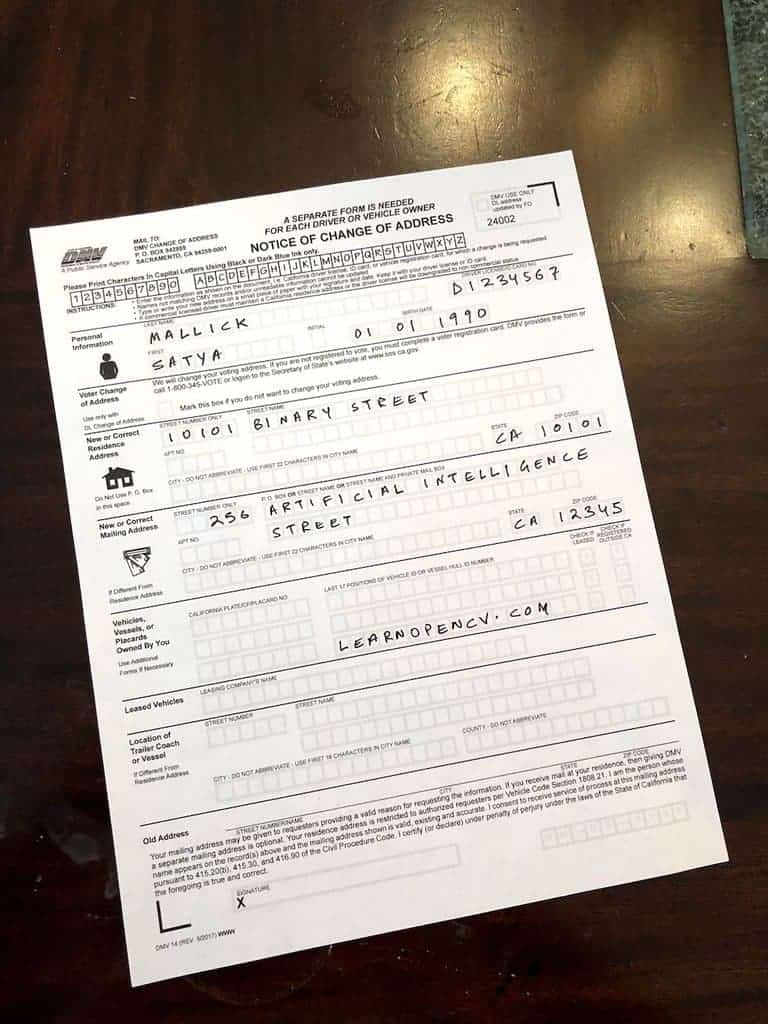

In [5]:
# Load the image
img = cv2.imread('/content/opencv123.jpg')
cv2_imshow(img)
cv2.waitKey(0)
orig_img = img.copy()

In [6]:
dimensions = img.shape
height = img.shape[0]
width = img.shape[1]
channels = img.shape[2]
print('Image Dimension    : ',dimensions)
print('Image Height       : ',height)
print('Image Width        : ',width)
print('Number of Channels : ',channels)

Image Dimension    :  (1024, 768, 3)
Image Height       :  1024
Image Width        :  768
Number of Channels :  3


In [7]:
# Repeated Closing operation to remove text from the document.
kernel = np.ones((5,5),np.uint8)
img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations= 3)

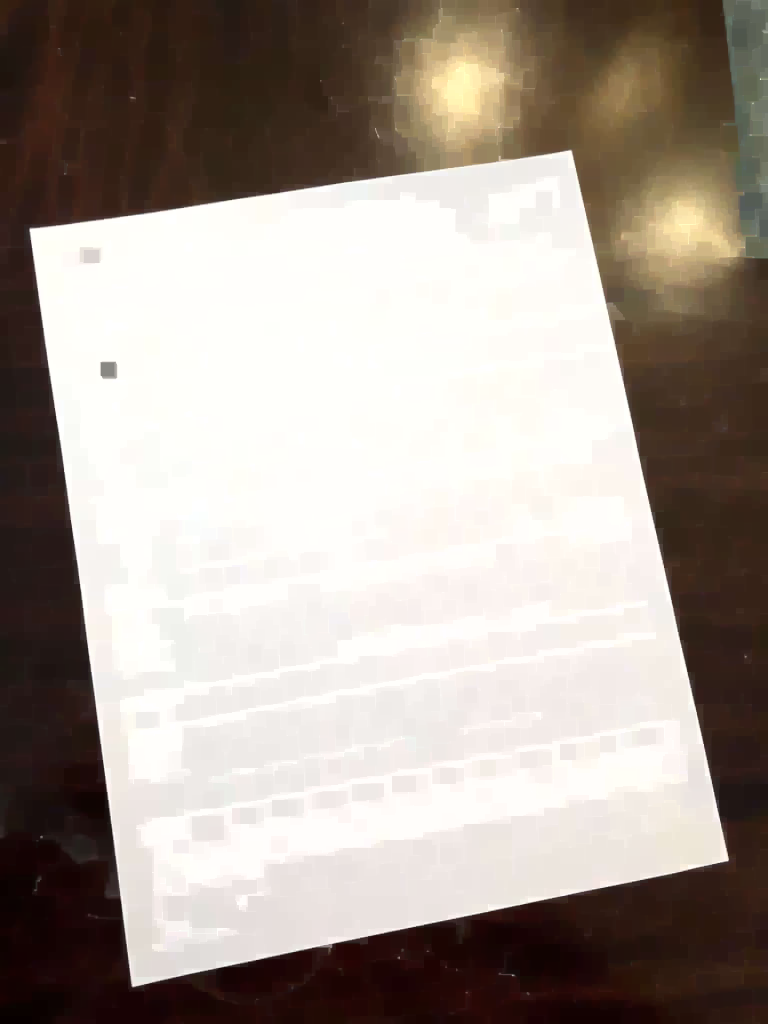

In [8]:
cv2_imshow(img)

In [9]:
mask = np.zeros(img.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = (20,20,img.shape[1]-20,img.shape[0]-20)
cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]

In [10]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (11, 11), 0)
# Edge Detection.
canny = cv2.Canny(gray, 0, 100)
canny = cv2.dilate(canny, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))

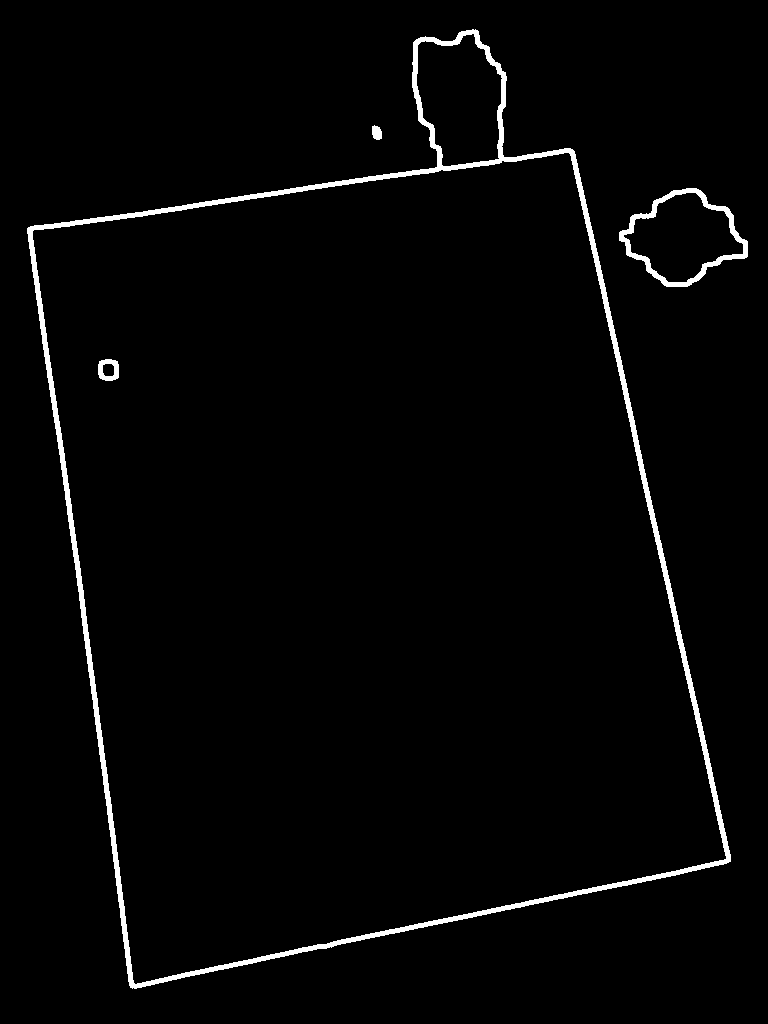

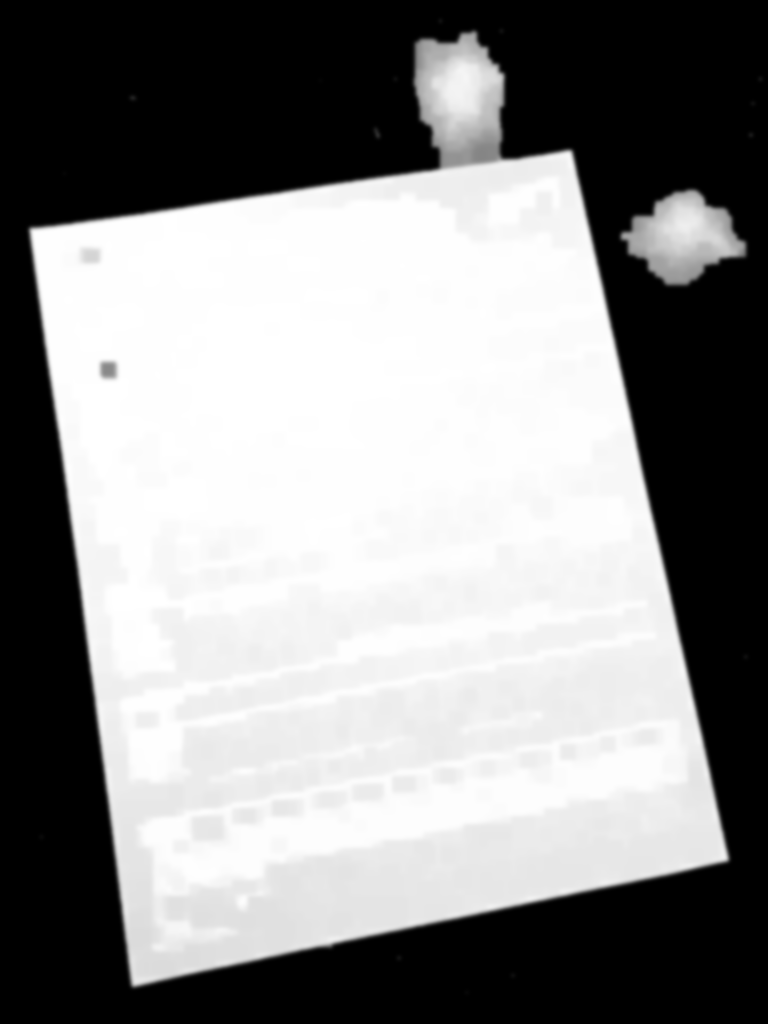

In [11]:
cv2_imshow(canny)
cv2_imshow(gray)

In [12]:
# Blank canvas.
con = np.zeros_like(img)
# Finding contours for the detected edges.
contours, hierarchy = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
# Keeping only the largest detected contour.
page = sorted(contours, key=cv2.contourArea, reverse=True)[:5]
con = cv2.drawContours(con, page, -1, (0, 255, 255), 3)

In [13]:
con.shape

(1024, 768, 3)

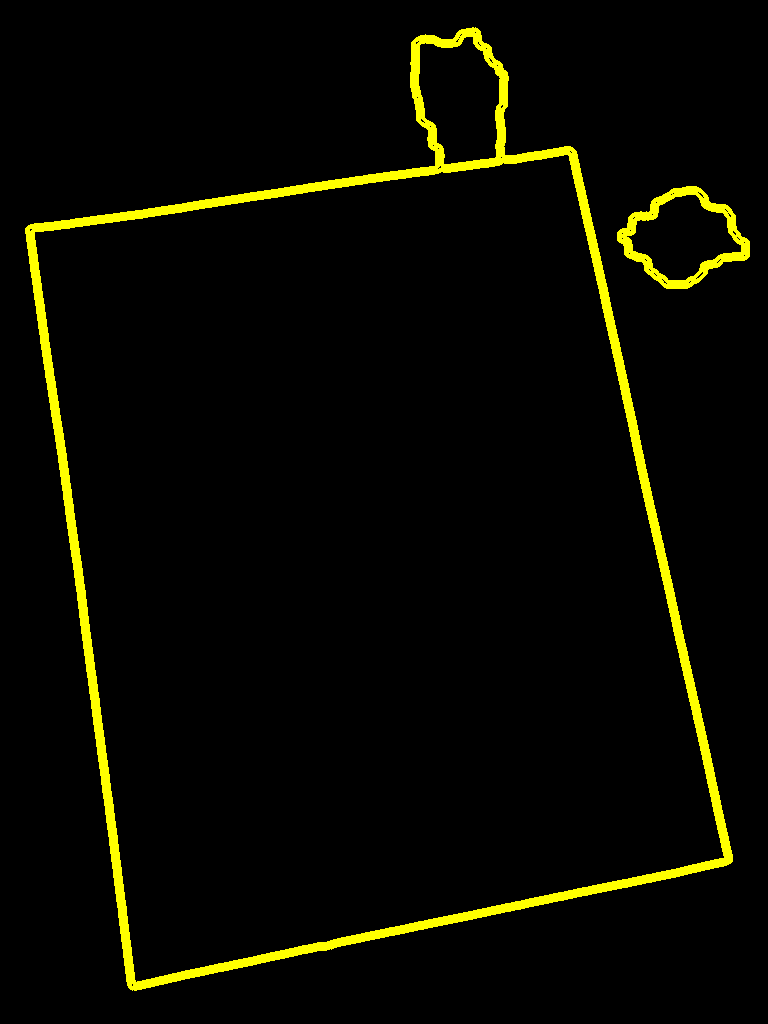

In [14]:
cv2_imshow(con)

[[32, 231], [135, 984], [568, 152], [726, 858]]


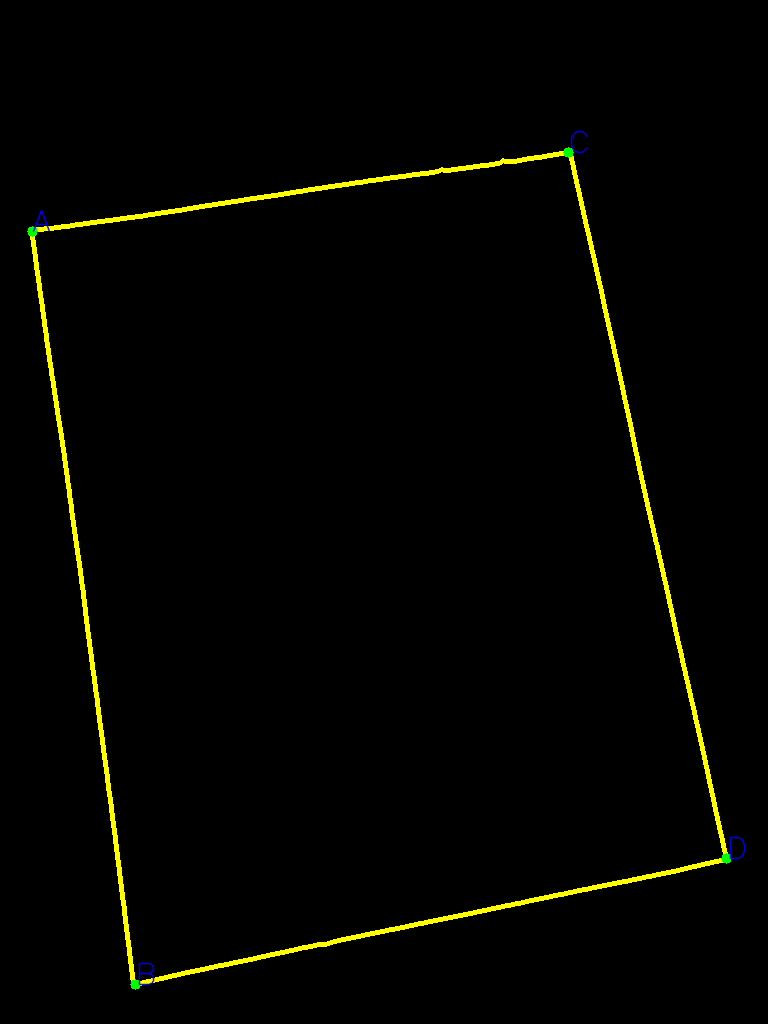

[[32, 231], [135, 984], [568, 152], [726, 858]]


(1024, 768, 3)

In [15]:
# Blank canvas.
con = np.zeros_like(img)
# Loop over the contours.
for c in page:
  # Approximate the contour.
  epsilon = 0.02 * cv2.arcLength(c, True)
  corners = cv2.approxPolyDP(c, epsilon, True)
  # If our approximated contour has four points
  if len(corners) == 4:
      break
cv2.drawContours(con, c, -1, (0, 255, 255), 3)
cv2.drawContours(con, corners, -1, (0, 255, 0), 10)
# Sorting the corners and converting them to desired shape.
corners = sorted(np.concatenate(corners).tolist())
#corners
 
# Displaying the corners.
for index, c in enumerate(corners):
  character = chr(65 + index)
  cor = cv2.putText(con, character, tuple(c), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1, cv2.LINE_AA)
print(corners)
cv2_imshow(cor)
print(corners)
cor.shape
#corners.shape

In [16]:
corners = np.array(corners)

In [17]:
def order_points_new(corners):
    # sort the points based on their x-coordinates
    xSorted = corners[np.argsort(corners[:, 0]), :]
    # grab the left-most and right-most points from the sorted
    # x-roodinate points
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]

    # now, sort the left-most coordinates according to their
    # y-coordinates so we can grab the top-left and bottom-left
    # points, respectively
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost

    # if use Euclidean distance, it will run in error when the object
    # is trapezoid. So we should use the same simple y-coordinates order method.

    # now, sort the right-most coordinates according to their
    # y-coordinates so we can grab the top-right and bottom-right
    # points, respectively
    rightMost = rightMost[np.argsort(rightMost[:, 1]), :]
    (tr, br) = rightMost

    # return the coordinates in top-left, top-right,
    # bottom-right, and bottom-left order
    #pts= np.array([tl, tr, br, bl], dtype="float32")
    return np.array([tl, tr, br, bl], dtype="float32")
   

In [18]:
type(corners)

numpy.ndarray

In [19]:
pts = order_points_new(corners)
tl, tr, br, bl = pts

In [20]:
corners
pts

array([[ 32., 231.],
       [568., 152.],
       [726., 858.],
       [135., 984.]], dtype=float32)

In [21]:
#pts = np.array([tl, tr, br, bl], dtype="float32")

In [22]:
#pts = np.array([[1085, 242],[107, 258],[1208, 1544],[105, 1601]])

In [23]:
print(pts)
print(br[0])
print(bl[0])
print(br[1])
print(bl[1])

[[ 32. 231.]
 [568. 152.]
 [726. 858.]
 [135. 984.]]
726.0
135.0
858.0
984.0


In [24]:
#pts = np.array([[10,10],
               #[10,20],
               #[20,20],
               #[30,10]])

In [33]:
(tl, tr, br, bl) = pts
# Finding the maximum width.
widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
maxWidth = max(int(widthA), int(widthB))
# Finding the maximum height.
heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
maxHeight = max(int(heightA), int(heightB))
# Final destination co-ordinates.
destination_corners = np.array([[0, 0],[0, maxHeight],[maxWidth,0],[maxWidth, maxHeight]], dtype="float32")
destination_corners

array([[  0.,   0.],
       [  0., 760.],
       [604.,   0.],
       [604., 760.]], dtype=float32)

In [34]:
#dst = np.array([
#	[0, 0],
#	[maxWidth - 1, 0],
#	[maxWidth - 1, maxHeight - 1],
#	[0, maxHeight - 1]], dtype = "float32")

In [35]:
print(widthA)
print(widthB)
print(maxWidth)
print(heightA)
print(heightB)
print(maxHeight)

604.2822188348752
541.7905499360431
604
723.463889907437
760.0118420130044
760


In [36]:
# Getting the homography.
#pts = np.array([[1085, 242],[107, 258],[1208, 1544],[105, 1601]])
#pts2 = np.array(destination_corners)
#M = cv2.getPerspectiveTransform(np.float32(pts),np.float32(pts2))
M = cv2.getPerspectiveTransform(np.float32(corners), np.float32(destination_corners))
print(M)
# Perspective transform using homography.
final = cv2.warpPerspective(orig_img, M,(maxWidth,maxHeight), flags=cv2.INTER_LINEAR)

[[ 1.09400508e+00 -1.49644785e-01 -4.40217184e-01]
 [ 1.69211972e-01  1.14807110e+00 -2.70619207e+02]
 [-6.28169976e-05  1.71656230e-04  1.00000000e+00]]


1755
Image Width        :  1240

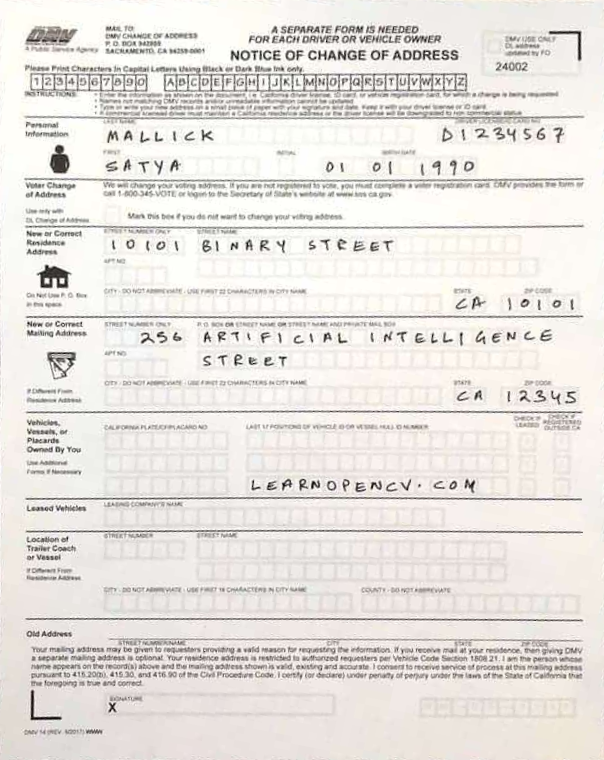

In [37]:
cv2_imshow(final)

In [30]:
def scan(img):
    # Resize image to workable size
    dim_limit = 1080
    max_dim = max(img.shape)
    if max_dim > dim_limit:
        resize_scale = dim_limit / max_dim
        img = cv2.resize(img, None, fx=resize_scale, fy=resize_scale)
    # Create a copy of resized original image for later use
    orig_img = img.copy()
    # Repeated Closing operation to remove text from the document.
    kernel = np.ones((5, 5), np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=3)
    # GrabCut
    mask = np.zeros(img.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    rect = (20, 20, img.shape[1] - 20, img.shape[0] - 20)
    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    img = img * mask2[:, :, np.newaxis]
 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (11, 11), 0)
    # Edge Detection.
    canny = cv2.Canny(gray, 0, 00)
    canny = cv2.dilate(canny, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))
 
    # Finding contours for the detected edges.
    contours, hierarchy = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # Keeping only the largest detected contour.
    page = sorted(contours, key=cv2.contourArea, reverse=True)[:5]
 
    # Detecting Edges through Contour approximation.
    # Loop over the contours.
    if len(page) == 0:
        return orig_img
    for c in page:
        # Approximate the contour.
        epsilon = 0.02 * cv2.arcLength(c, True)
        corners = cv2.approxPolyDP(c, epsilon, True)
        # If our approximated contour has four points.
        if len(corners) == 4:
            break
    # Sorting the corners and converting them to desired shape.
    corners = sorted(np.concatenate(corners).tolist())
    # For 4 corner points being detected.
    corners = order_points_new(corners)
 
    destination_corners = find_dest(corners)
 
    h, w = orig_img.shape[:2]
    # Getting the homography.
    M = cv2.getPerspectiveTransform(np.float32(corners), np.float32(destination_corners))
    # Perspective transform using homography.
    final = cv2.warpPerspective(orig_img, M, (destination_corners[2][0], destination_corners[2][1]),
                                flags=cv2.INTER_LINEAR)
    return final

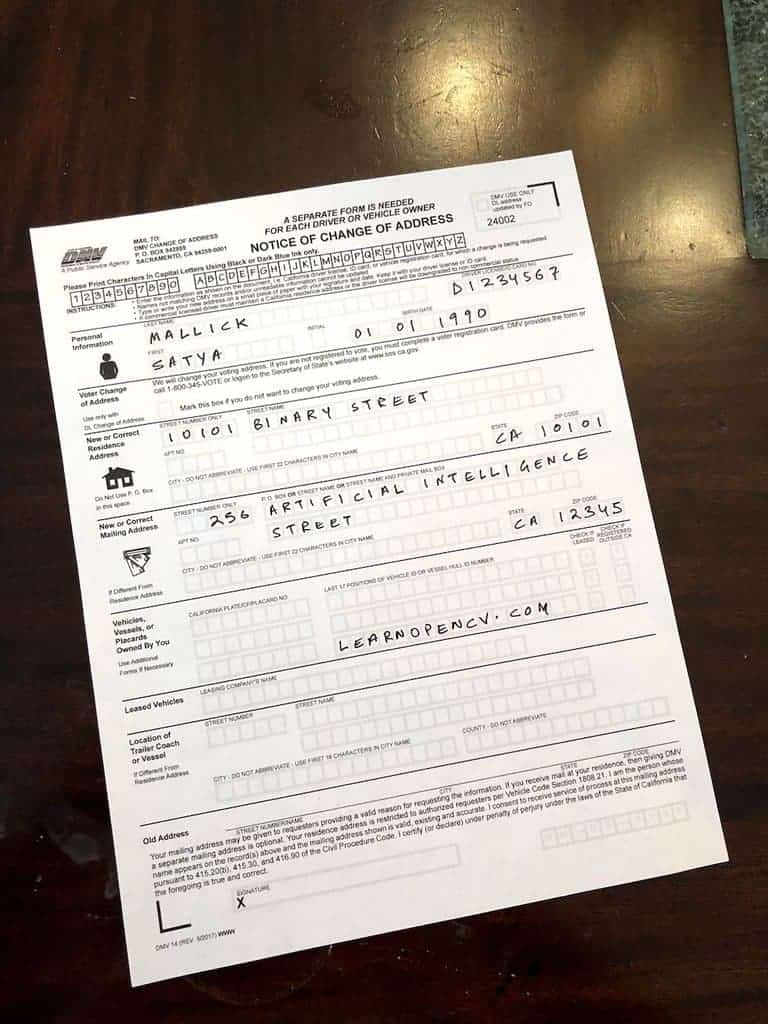

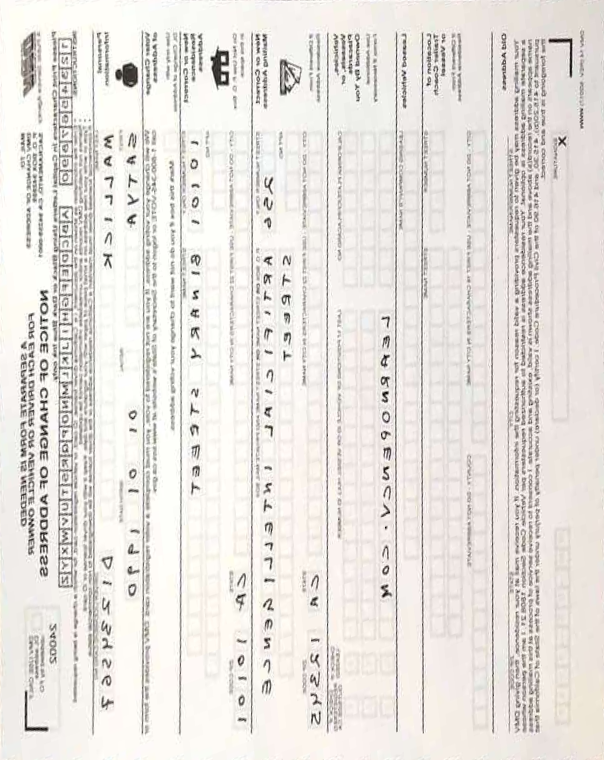

In [31]:
cv2_imshow(orig_img)
cv2_imshow(final)

In [32]:
(destination_corners[2][0], destination_corners[2][1])

(0.0, 760.0)